## Problem Statement

In this work, we consider the one-dimensional heat equation, which describes the distribution of heat (or variation in temperature) in a given region over time. The heat equation is given by the partial differential equation (PDE):

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

where \( u(x,t) \) represents the temperature at position \( x \) and time \( t \), and \( \alpha \) is the thermal diffusivity of the material.

## Initial and Boundary Conditions

To solve this PDE, we define the following initial and boundary conditions:

### Initial Condition

The initial condition specifies the temperature distribution at \( t = 0 \):

$$
u(x, 0) = \sin(\pi x), \quad 0 \leq x \leq 1
$$

### Boundary Conditions

The boundary conditions specify the temperature at the boundaries of the domain for all time \( t \):

$$
u(0, t) = 0 \quad \text{and} \quad u(1, t) = 0, \quad t \geq 0
$$

## Parameters

The parameter used in the heat equation is:

$$
\alpha = 0.01 \quad \text{(thermal diffusivity)}
$$


## Neural Network Model: HeatPINN

We use a neural network model called `HeatPINN` to approximate the solution of the heat equation. The model consists of two layers, each with 50 neurons, using the Tanh activation function.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, clear_output

# Define the neural network model
class HeatPINN(nn.Module):
    def __init__(self):
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x, t):
        xt = torch.cat([x.view(-1, 1), t.view(-1, 1)], dim=1)
        return self.net(xt)

## Device Configuration and Model Initialization

In this part of the code, we set up the device configuration, initialize the `HeatPINN` model, and define the optimizer.

### Device Configuration


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeatPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Defining the PDE and Enforcing Boundary/Initial Conditions

The `compute_loss` function calculates the loss for training the Physics-Informed Neural Network (PINN), ensuring adherence to the PDE, initial conditions (IC), and boundary conditions (BC).

### Explanation

1. **Automatic Differentiation**:
    - Enables gradient computation for $x$ and $t$.

2. **Model Prediction**:
    - Predicts temperature $u$ using the neural network.

3. **Derivative Calculation**:
    - Computes $u_t$, $u_x$, and $u_{xx}$ using automatic differentiation.

4. **PDE Residual**:
    - Calculates the residual $u_t - \alpha u_{xx}$.

5. **Boundary Conditions**:
    - Ensures $u(0, t) = 0$ and $u(1, t) = 0$.

6. **Initial Condition**:
    - Ensures $u(x, 0) = \sin(\pi x)$.

7. **Loss Calculation**:
    - Combines PDE residual, BC, and IC losses.

###

`compute_loss` ensures the model predictions adhere to the PDE, IC, and BC, making the solution physically consistent.


In [ ]:
alpha = 0.01  # thermal diffusivity, adjust as needed
epochs = 1000

def compute_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    
    u = model(x, t)
    
    # Calculate derivatives
    u_t = torch.autograd.grad(u, t, torch.ones(t.shape, device=device), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones(x.shape, device=device), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones(x.shape, device=device), create_graph=True)[0]
    
    residual = u_t - alpha * u_xx
    
    u_0_t = model(torch.zeros_like(t), t)
    u_1_t = model(torch.ones_like(t), t)
    
    u_x_0 = model(x, torch.zeros_like(x)) - torch.sin(np.pi * x)
    
    loss = torch.mean(residual**2) + torch.mean(u_0_t**2) + torch.mean(u_1_t**2) + torch.mean(u_x_0**2)
    return loss


## Training Data Preparation

- Create linearly spaced grids for $x$ (0 to 1) and $t$ (0 to 0.5).
- Generate a meshgrid to combine $x$ and $t$ points.
- Reshape the meshgrid for model input.

This setup provides a continuous spatial and temporal domain for training the PINN.


In [ ]:
# Training data
x = torch.linspace(0, 1, 100).view(-1, 1).to(device)
t = torch.linspace(0, 0.5, 100).view(-1, 1).to(device)
X, T = torch.meshgrid(x.flatten(), t.flatten(), indexing='ij')
X = X.to(device).reshape(-1, 1)
T = T.to(device).reshape(-1, 1)

## Training Loop

- Iterate over epochs.
- Compute loss, backpropagate, and update model.
- Periodically update plot to visualize predictions.

This process trains the PINN to satisfy the PDE, IC, and BC.


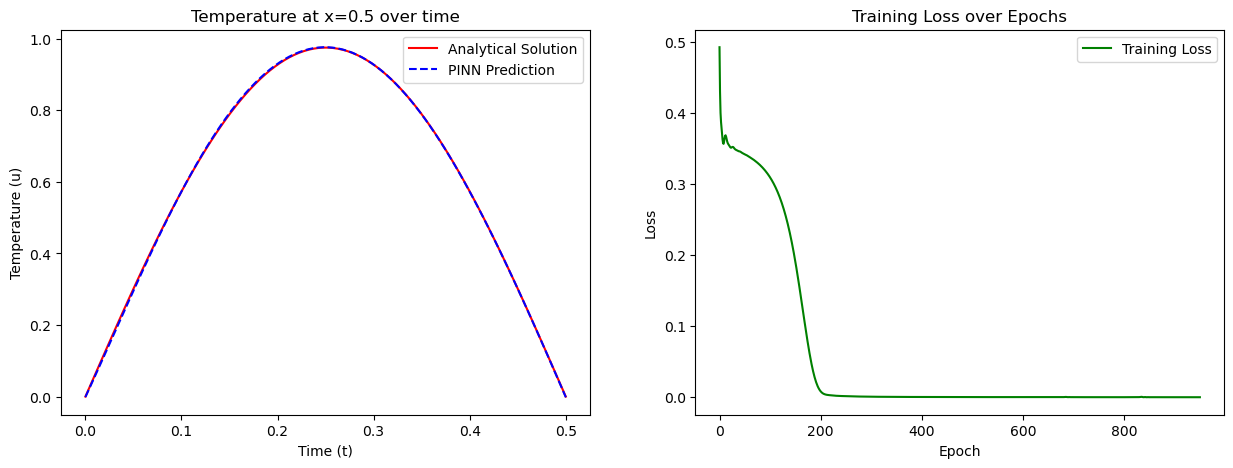

Training Model: 100%|██████████| 1000/1000 [00:19<00:00, 50.21it/s]


In [3]:

# Prepare plot
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First panel
line1, = ax1.plot([], [], 'r-', label='Analytical Solution')
line2, = ax1.plot([], [], 'b--', label='PINN Prediction')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Temperature (u)')
ax1.set_title('Temperature at x=0.5 over time')
ax1.legend()

# Second panel
line3, = ax2.plot([], [], 'g-', label='Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss over Epochs')
ax2.legend()

display(fig)

loss_history = []

# Training loop with live updates
for epoch in tqdm(range(epochs), desc="Training Model"):
    optimizer.zero_grad()
    loss = compute_loss(model, X, T)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 50 == 0:
        with torch.no_grad():
            u_pred = model(X, T).view(100, 100)[:, 50].cpu().numpy()  # Predictions at x=0.5
            X_np = X.cpu().detach().numpy()
            T_np = T.cpu().detach().numpy()
            U_analytical = np.sin(np.pi * X_np) * np.exp(-np.pi**2 * alpha * T_np)
            
            # Update first panel
            line1.set_data(t.cpu().numpy(), U_analytical.reshape(100, 100)[:, 50])
            line2.set_data(t.cpu().numpy(), u_pred)
            ax1.relim()
            ax1.autoscale_view()

            # Update second panel
            line3.set_data(range(len(loss_history)), loss_history)
            ax2.relim()
            ax2.autoscale_view()

            clear_output(wait=True)
            display(fig)
            plt.pause(0.01)  # Pause to update the plot
            
plt.ioff()
plt.show()



## Illustrating Results and Comparison

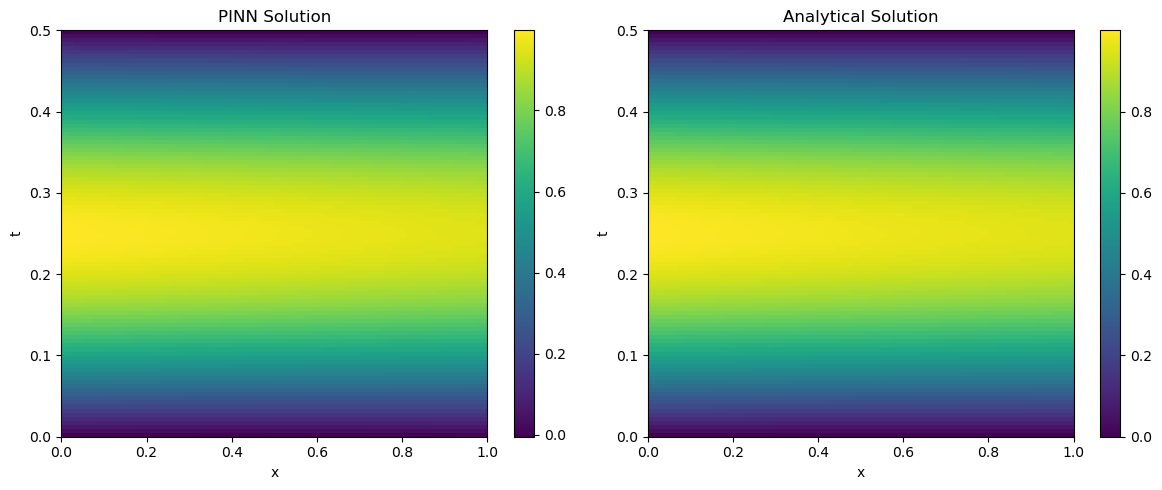

In [4]:
# Analytical solution
X_np = X.cpu().detach().numpy()
T_np = T.cpu().detach().numpy()
U_analytical = np.sin(np.pi * X_np) * np.exp(-np.pi**2 * alpha * T_np)

# Visualization of results
with torch.no_grad():
    u_pred = model(X, T).reshape(100, 100).cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(u_pred, extent=[0, 1, 0, 0.5], origin='lower', aspect='auto')
plt.colorbar()
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('t')

plt.subplot(1, 2, 2)
plt.imshow(U_analytical.reshape(100, 100), extent=[0, 1, 0, 0.5], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Analytical Solution')
plt.xlabel('x')
plt.ylabel('t')

plt.tight_layout()
plt.show()
